In [172]:
# en = args.encoder_layers
# de= args.decoder_layers
# random.seed(3000)
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
import nibabel as nib
import tqdm
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from utils import *
import pathlib
import surfa as sf


mgh = pathlib.Path('fetus_label_map')
mgh_files = list(mgh.glob('*.nii.gz'))
# label_maps = [np.uint8(sf.load_volume(str(file_path)).resize([1,1,1],method='nearest').data) for file_path in mgh_files]

label_maps = [np.uint8(sf.load_volume(str(file_path)).data) for file_path in mgh_files]


# label_maps = crop_img(label_maps,dimx,dimy,dimz)
labels = np.unique(label_maps)
in_shape = label_maps[0].shape


labels = np.unique(label_maps)
num_labels=8
# labels_in = range(max(labels) + num_labels + 1)
labels_in = np.unique(label_maps) # change this for feta

feta = pathlib.Path('/autofs/space/bal_004/users/jd1677/synthstrip/feta_3d')
feta_files = list(feta.glob('sub-???/anat/sub-???_rec-mial_dseg.nii.gz'))
feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]


In [173]:
print(labels_in)
dim_=256

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [174]:


from scipy.ndimage import binary_dilation, gaussian_filter
from scipy.ndimage import binary_dilation, binary_erosion, gaussian_filter
from skimage.morphology import ball

from scipy.ndimage import binary_dilation, binary_erosion
from skimage.morphology import ball

import numpy as np


from scipy.ndimage import center_of_mass

from scipy.ndimage import center_of_mass


import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage.measurements import center_of_mass

import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage.measurements import center_of_mass

import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage.measurements import center_of_mass



def generate_random_label_maps_feta(brain_maps1, fov_maps):
    return [
        np.roll(
            brain_maps1[selected_brain_index] + fov * (brain_maps1[selected_brain_index] == 0),
            np.round(np.random.uniform(0.2, 0.8, size=2) * np.array(brain_maps1[selected_brain_index].shape[:2])) * np.random.choice([-1, 1], size=2),
            axis=(0, 1)
        )
        for selected_brain_index, fov in zip(np.random.choice(len(brain_maps1), len(fov_maps)), fov_maps)
    ]



    
    
from skimage import transform
import numpy as np

from scipy.ndimage import binary_dilation
from skimage.transform import rescale

def scale_brain_maps(brain_maps, scale_factor):
    target_shape = (256, 256, 256)
    return [
        np.pad(
            rescale(b.astype(float), scale_factor, anti_aliasing=True, preserve_range=True).astype(int),
            [(0, max(0, target_shape[i] - rescale(b.astype(float), scale_factor, anti_aliasing=True, preserve_range=True).shape[i])) for i in range(3)],
            mode='constant'
        )
        for b in brain_maps
    ]
    
def get_fov(a, max_shift=60):
    a_copy = np.copy(a)
    best_directions = []
    for i in range(len(a)):
        b = a_copy[i]
        m = (b >= 1) & (b < 8)
        m = binary_dilation((m > 0), structure=np.ones((2, 2, 2)))

        max_sum = 0
        best_shift = 0
        best_direction = 0

        for d in range(3):
            for shift in range(-max_shift, max_shift + 1):
                shifted_m = np.roll(m, shift, axis=d)
                current_sum = np.sum(b[shifted_m])

                if current_sum > max_sum:
                    max_sum = current_sum
                    best_shift = shift
                    best_direction = d

        shifted_m = np.roll(m, best_shift, axis=best_direction)
        best_directions.append(best_direction)
        b[m] = 0
        b[m] = a_copy[i][shifted_m]
        
        a_copy[i] = b

    return a_copy , best_directions



# Show.
print(len(label_maps),np.max(label_maps[0]))
# gen = generator(label_maps)
num_row = 2
per_row = 8

brain_maps = get_brain(label_maps)
# brain_maps = scale_brain_maps(feta_label_maps[0:10], scale_factor=0.5)
# print(brain_maps[0].shape,len(brain_maps))

fov_maps, best_directions = get_fov(label_maps)

# # fov_maps1 = label_maps

# # random_label_maps = generate_random_label_maps_feta(brain_maps, label_maps)#, best_directions,num_maps=10)
# # ne.plot.volume3D(brain_maps[0])
# for i in range(10):
#     ne.plot.volume3D(random_label_maps[i],cmaps=['tab20c'])
#     nib.save(nib.Nifti1Image(random_label_maps[i].astype(np.int32), np.eye(4), header=None), f"feta_samples/label_map_{i}.nii.gz")

# ne.plot.volume3D(label_maps[0])


10 16


In [168]:
# print(len(random_label_maps),len(brain_maps),np.sum(label_maps[0]))
print(labels_in)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


(None, 256, 256, 256, 1)
(None, 256, 256, 256, 1)
(None, 256, 256, 256, 1)
(None, 256, 256, 256, 1)
(None, 256, 256, 256, 1)
(None, 256, 256, 256, 1)


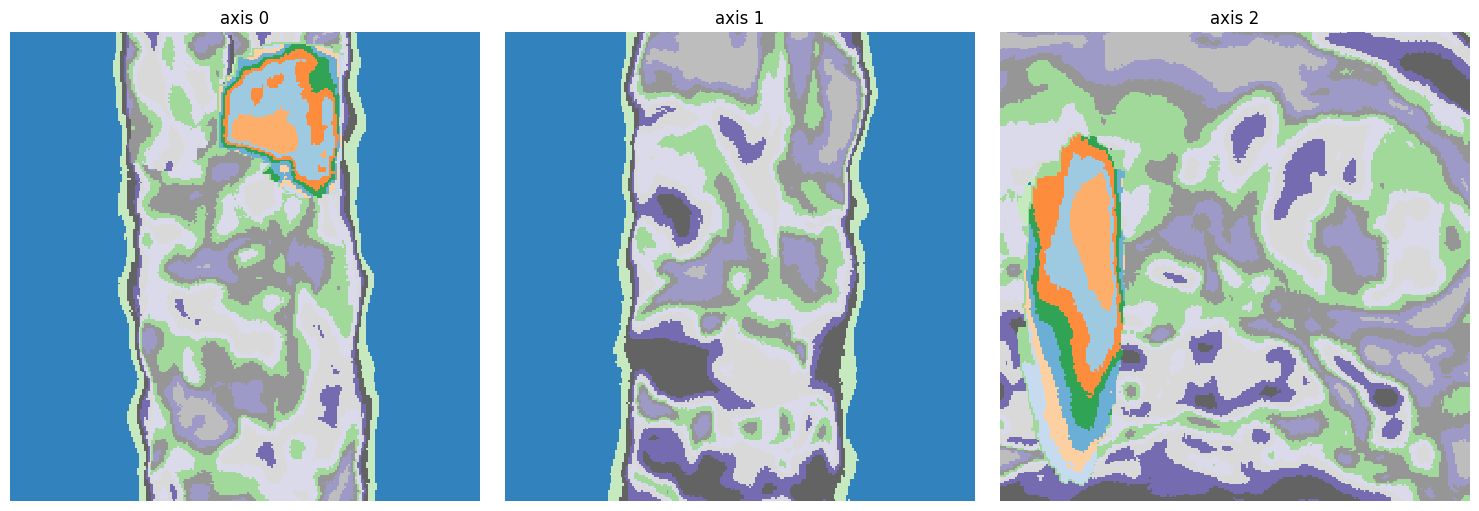

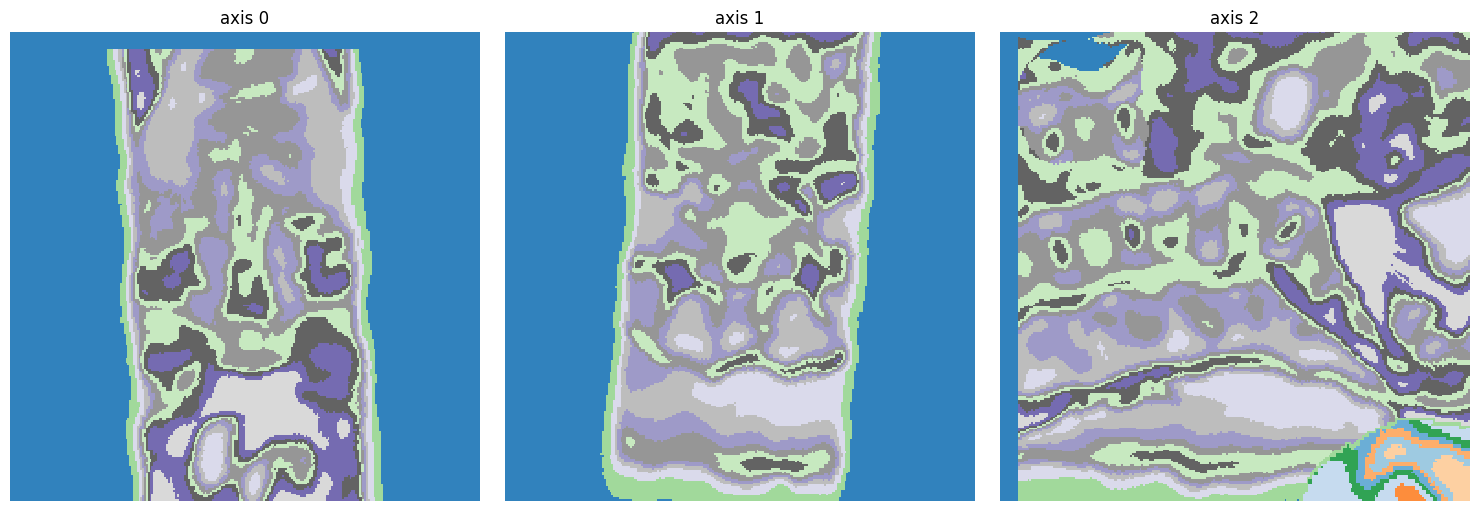

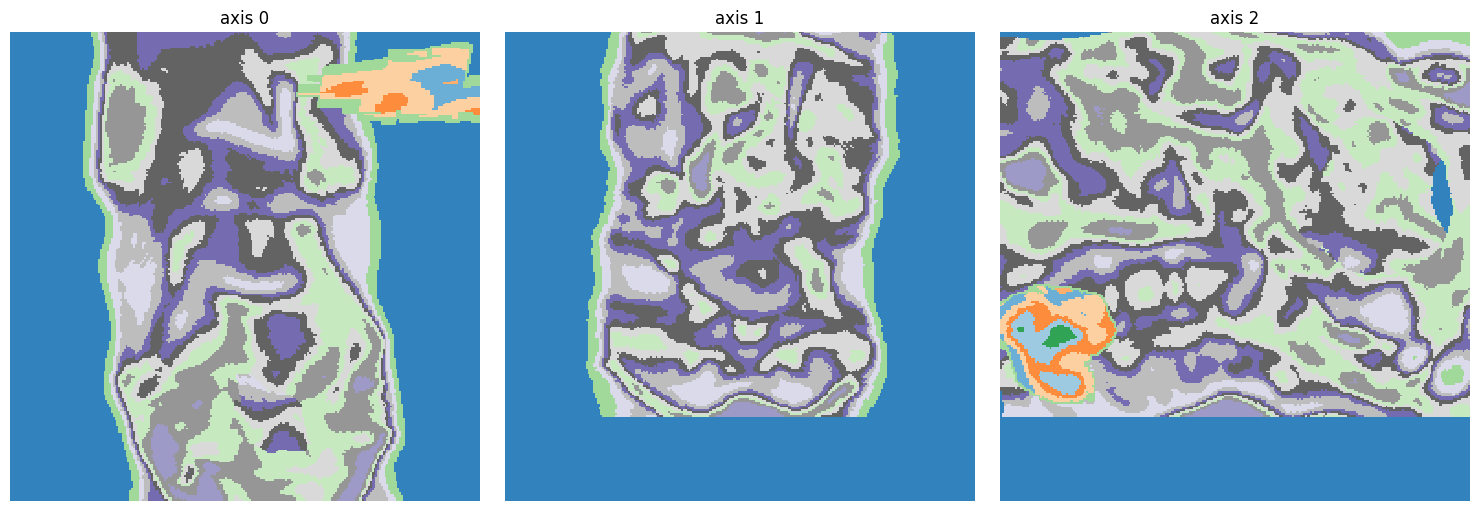

In [176]:
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation

#brain
model1 = ne.models.labels_to_image_new(
    in_shape=in_shape,
    labels_in=labels_in,
    labels_out={i: i if i in (1, 2, 3, 4, 5, 6, 7) else 0 for i in labels_in},
    warp_min=0.05,  # Adjust this value for a small warping change
    warp_max=0.2,  # Adjust this value for a small warping change
    one_hot=False,
    aff_rotate=20,
    aff_shift=20,
    up_scale=False,
    aff_scale=2

)

#body
model2 = ne.models.labels_to_image_new(
    in_shape=in_shape,
    labels_in=labels_in,
    labels_out={i: 0 if i in (1, 2, 3, 4, 5, 6, 7) else i for i in labels_in},
    aff_rotate=5,
    aff_shear=0.0,
    blur_max=1,
    warp_min=0.01,  # Adjust this value for a small warping change
    warp_max=2,  # Adjust this value for a small warping change
    slice_prob=1,
    one_hot=False,
    crop_prob=1,
    aff_scale=0.2

)

model3 = ne.models.labels_to_image_new(
    in_shape=in_shape,
    labels_in=labels_in,
    labels_out={f: 1 if f in (1, 2, 3, 4, 5, 6, 7) else 0 for f in labels_in},
    warp_min=0.01,  # Adjust this value for a small warping change
    warp_max=2,  # Adjust this value for a small warping change
    blur_max=1,
    noise_min=0.0,
    noise_max=0.1,
    one_hot=True,
    zero_background=0.2,
    aff_scale=0.5,
    mean_min=[0.2 if f in (1, 2, 3, 4, 5, 6, 7) else 0.0 for f in labels_in],
    mean_max=[1.0 if f in (1, 2, 3, 4, 5, 6, 7) else 0.8 for f in labels_in]

)


num_gen = 3
output_labels = []

for i in range(num_gen):
    gen1 = generatorFOV(brain_maps, fov_maps)
    
    input_brain, input_fov = next(gen1)
    
    _ , output_brain = model1(input_brain)
    _ , output_fov = model2(input_fov)
    
    output_brain = np.squeeze(output_brain, axis=(0, -1))
    output_fov = np.squeeze(output_fov, axis=(0, -1))


    output_brain = output_brain.copy()
    output_fov = output_fov.copy()

    # brain_maps = add_ring(brain_maps)
    
    output_label = gen_brain_fov_non_flip(brain_maps, fov_maps, model1, model2)
    output_labels.append(output_label)
    nib.save(nib.Nifti1Image(np.squeeze(output_label, axis=(0, -1)).astype(np.int32), np.eye(4), header=None), f"samples/label_map_{i}.nii.gz")

    ne.plot.volume3D(np.squeeze(output_label, axis=(0, -1)), cmaps=['tab20c'])

            


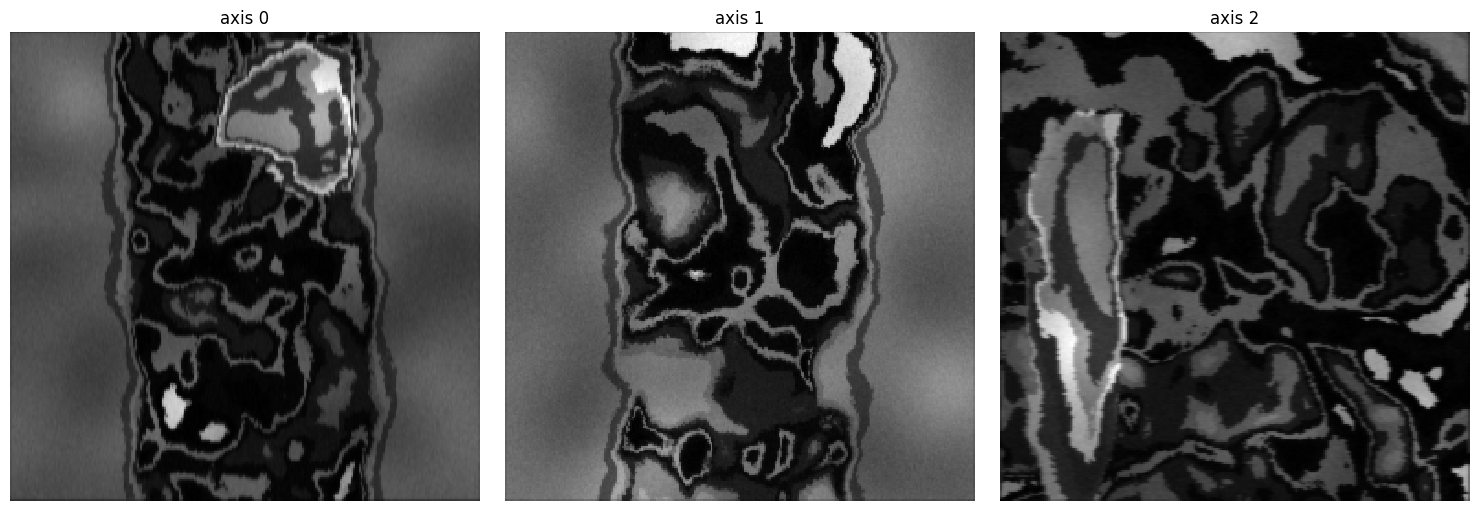

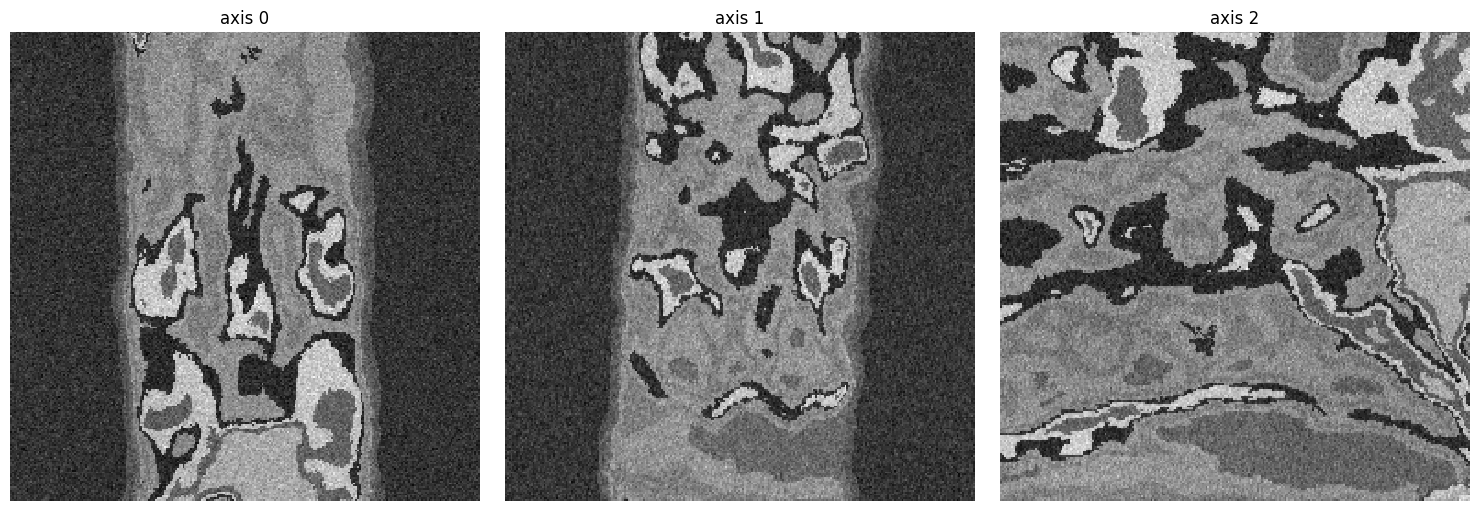

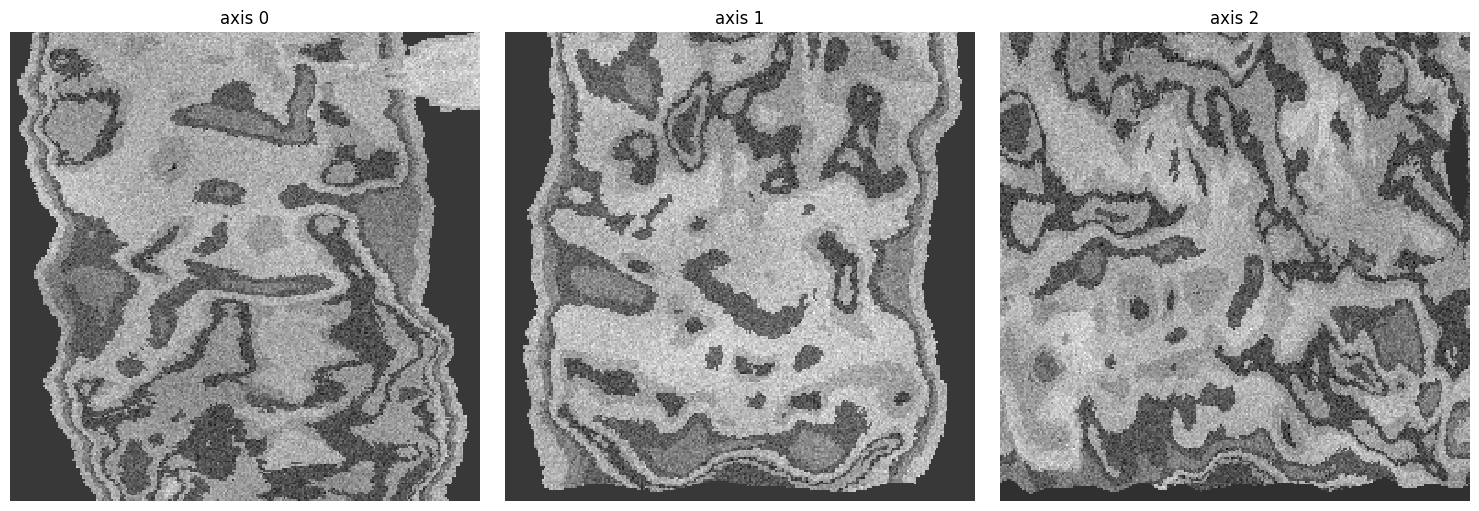

In [177]:
# images, one_hot = zip(*[model3.predict(output_labels[0], verbose=0) for _ in range(num_gen)])
images = []
one_hots = []
for i in range(num_gen):
    im, oh = zip(*[model3.predict(output_labels[i], verbose=0) for _ in range(1)])
    nib.save(nib.Nifti1Image(np.squeeze(im[0], axis=(0, -1)), np.eye(4)), f"samples/synth_mgh{i}.nii.gz")
    nib.save(nib.Nifti1Image(np.argmax(oh[0],axis=-1).squeeze(axis=0).astype(np.int32), np.eye(4)), f"samples/mask_mgh{i}.nii.gz")
    ne.plot.volume3D(im)
    # # ne.plot.volume3D(oh)
    # for i in range(oh[0].shape[-1]):
    #     ne.plot.volume3D([f[..., i] for f in oh])

    
# for i in range(num_gen):
#     nib.save(nib.Nifti1Image(np.squeeze(images[i], axis=(0, -1)), np.eye(4)), f"samples/synth_mgh{i}.nii.gz")
#     nib.save(nib.Nifti1Image(one_hot[i].squeeze(axis=0).astype(np.int32), np.eye(4)), f"samples/mask_mgh{i}.nii.gz")






In [162]:
print(labels_in)

range(0, 25)


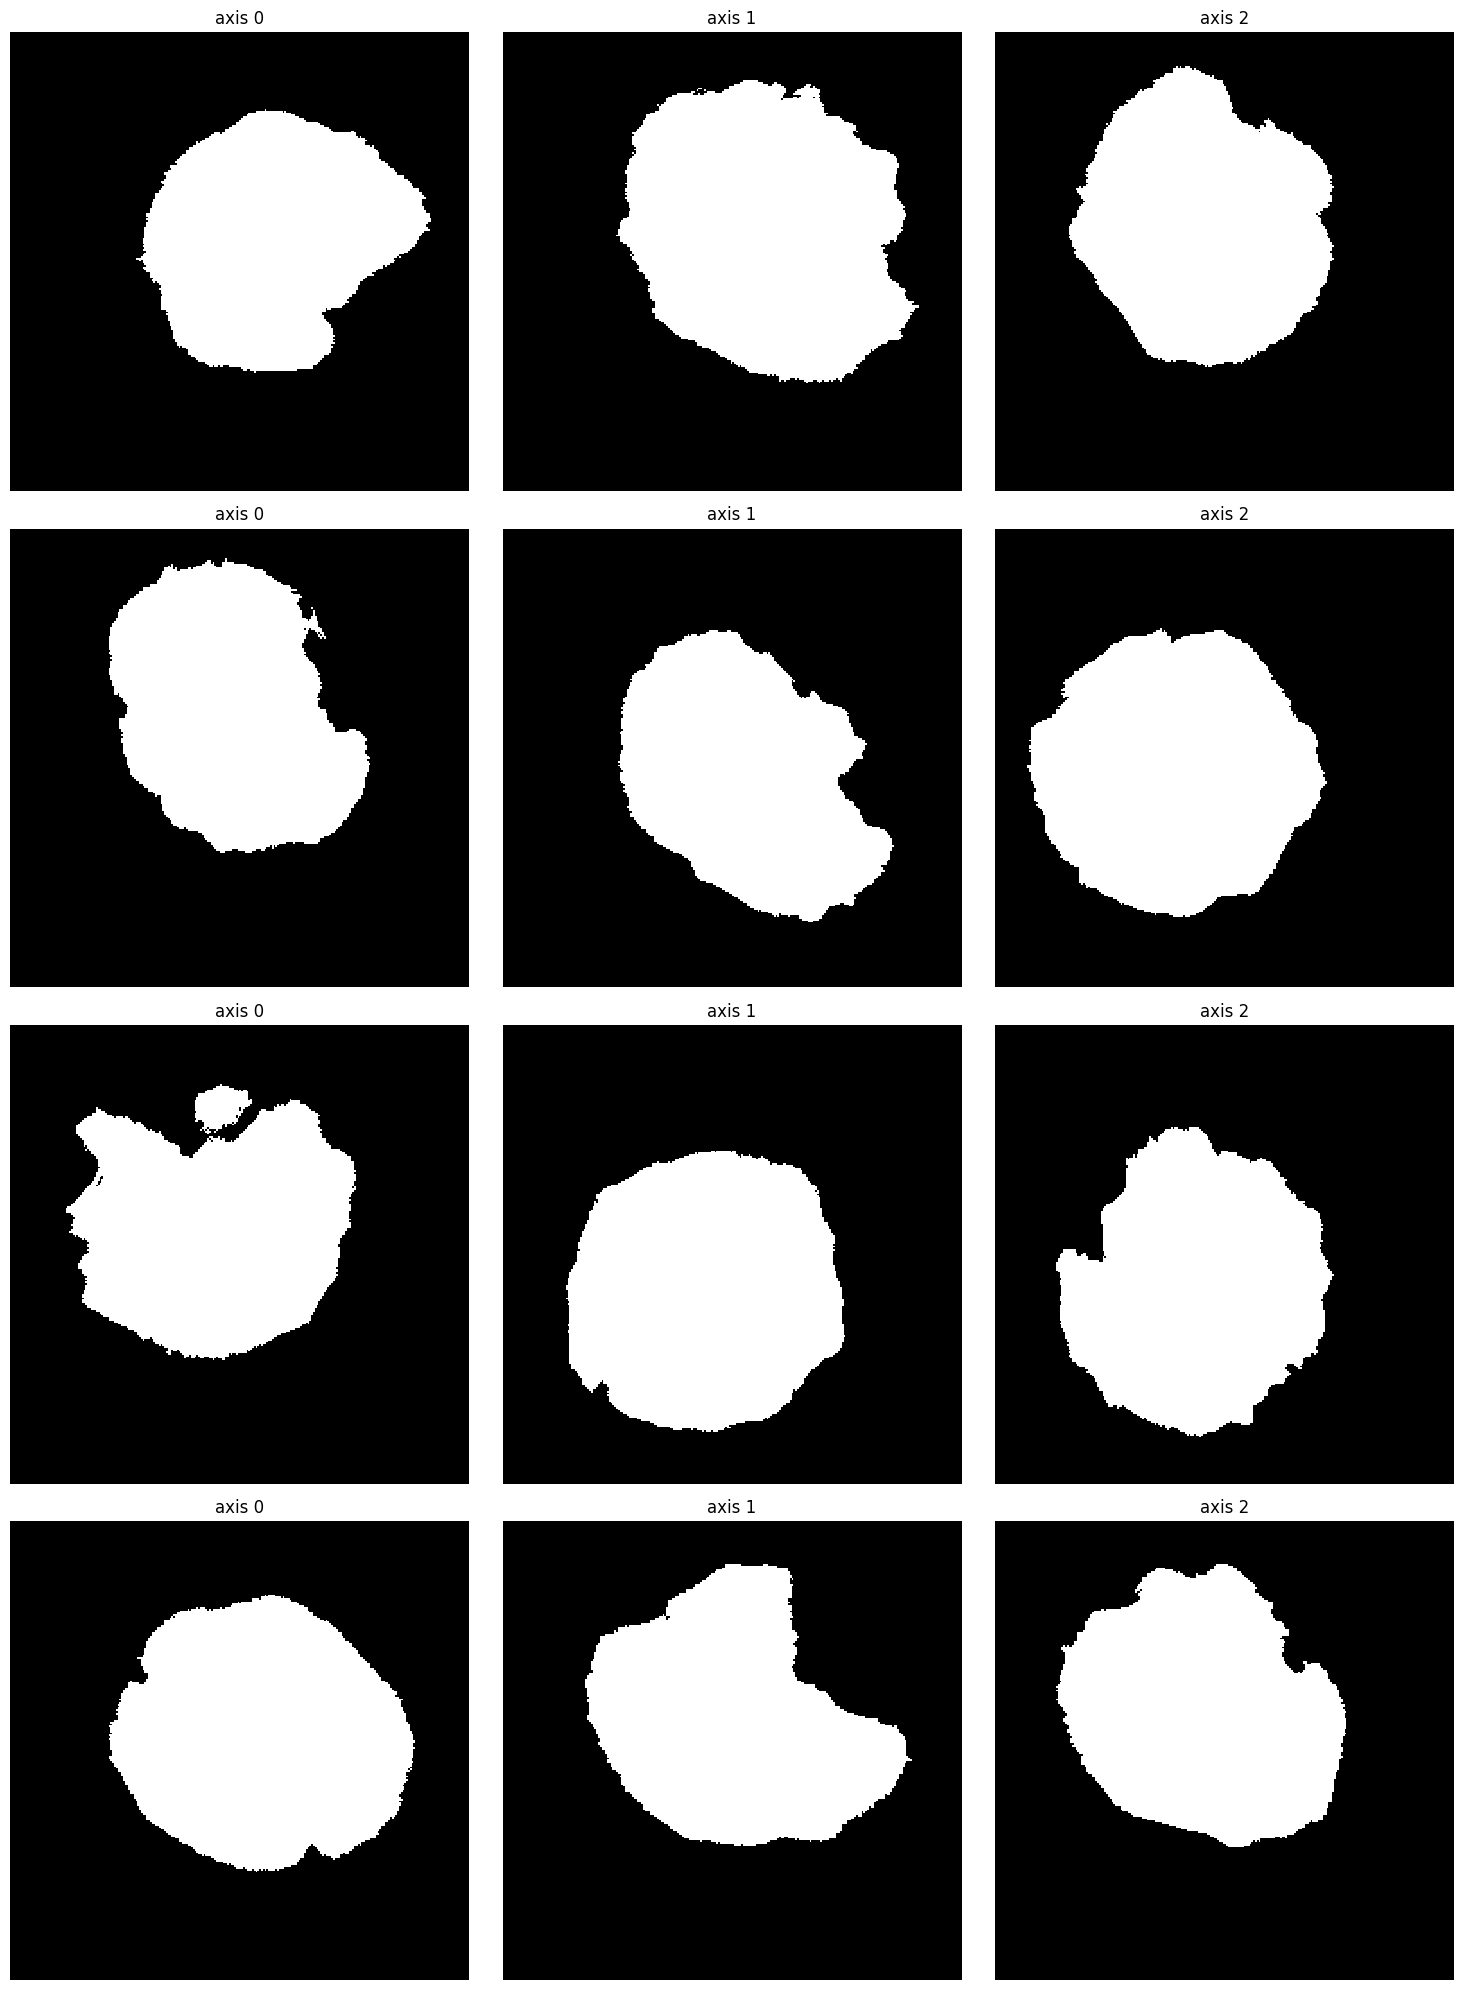

In [8]:
ne.plot.volume3D([f[..., i] for f in one_hot]);

In [9]:

# Combined model: synthesis and segmentation.
ima, true = model_gen.outputs
pred = model_seg(ima)
model = tf.keras.Model(inputs=model_gen.inputs, outputs=pred)


# Apparently, a proper soft-Dice loss squares the summands in the denominator.
def soft_dice(a, b):
    dim = len(a.shape) - 2
    space = list(range(1, dim + 1))

    top = 2 * tf.reduce_sum(a * b, axis=space)
    bot = tf.reduce_sum(a ** 2, axis=space) + tf.reduce_sum(b ** 2, axis=space)
    
    out = tf.divide(top, bot + 1e-6)
    return -tf.reduce_mean(out)


# Compile for training.
model.add_loss(soft_dice(true, pred))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


In [ ]:
# Training. Re-running cell will continue training.
reset = 0
epochs = 10
repeat = 2
import IPython.display


# Initialize.
if reset or 'log_epoch' not in locals():
    log_epoch = []
    log_loss = []


for _ in range(repeat):
    IPython.display.clear_output(wait=True)
    if log_epoch:
        plt.plot(log_epoch, log_loss, '.-')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        
    init = log_epoch[-1] + 1 if log_epoch else 0
    hist = model.fit(gen, initial_epoch=init, epochs=epochs + init, steps_per_epoch=100)
    log_epoch.extend(hist.epoch)
    log_loss.extend(hist.history['loss'])

Epoch 1/10


In [ ]:
num_test = 8


# Predict.
# imag, true = zip(*[model_gen.predict(next(gen), verbose=0) for _ in range(num_test)])
imag, true  = images, one_hot
pred = [model_seg.predict(i, verbose=0) for i in imag]
pred = [np.argmax(p[..., ::-1], axis=-1) for p in pred]
true = [np.argmax(t[..., ::-1], axis=-1) for t in true]


# Plot.
print('Input:')
ne.plot.volume3D(imag)

print('Prediction:')
ne.plot.volume3D(pred)

print('Ground truth:')
ne.plot.volume3D(true)

print('Difference:')
ne.plot.volume3D([p - t for p, t in zip(pred, true)]);